In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import qutip
from copy import deepcopy

from CoupledQuantumSystems.systems import FluxoniumOscillatorSystem
from CoupledQuantumSystems.drive import DriveTerm,square_pulse_with_rise_fall
from CoupledQuantumSystems.evo_parrallel import run_parallel_ODEsolve_and_post_process_jobs_with_different_systems

In [2]:
max_ql = 25
max_ol = 250
EJ = 4
EC = EJ/2.7
EL = EJ/45
Er = 10.38695526

g = 0.2
w_d = 10.389
amp = 0.015
kappa = 3e-3

tot_time =1000
tlist = np.linspace(0, tot_time, tot_time)
# system  =  FluxoniumOscillatorSystem(
#                 EJ = EJ,
#                 EC = EC,
#                 EL = EL,
#                 Er = Er,
#                 g_strength = g,
#                 kappa=kappa,
#                 qubit_level = max_ql,
#                 osc_level = max_ol,
#                 products_to_keep=[[ql, ol] for ql in range(15) for ol in range(max_ol) ],
#                 computaional_states = '0,2',
#                 )
# with open('gf_mcsolve_system_g2a015k003.pkl', 'wb') as f:
#     pickle.dump(system,f)

In [3]:

with open('gf_mcsolve_system_g2a015k003.pkl', 'rb') as f:
    system = pickle.load(f)

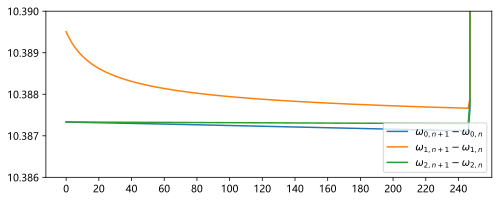

In [4]:
def dressed_ener(ql,ol):
    return system.evals[system.product_to_dressed[(ql,ol)]]

import matplotlib.pyplot as plt
plt.figure(figsize = (8,3))
n_osc_lvls = max_ol-1
dressed_osc_frequencies = [[] for _ in range(3)]
for j in [0,1,2]:
    for i in range(0,max_ol-1):
        dressed_osc_frequencies[j].append(dressed_ener(j,i+1)-dressed_ener(j,i))
        
for j in [0,1,2]:
    plt.plot(list(range(max_ol-1))[:n_osc_lvls], dressed_osc_frequencies[j][:n_osc_lvls],label=rf'$\omega_{{{j},n+1}} - \omega_{{{j},n}}$')

plt.xticks(list(range(n_osc_lvls))[::20])
plt.ylim(10.386, 10.390)
# plt.ylim(7.9,7.92)

# plt.xticklabels([str(i) for i in range(n_osc_lvls)])
plt.legend(loc='lower right')

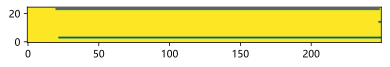

In [8]:
# id_wrapped_resonator_destory = qutip.tensor(qutip.identity(max_ql), qutip.destroy(max_ol))
# id_wrapped_fluxonium_destory = qutip.tensor(qutip.destroy(max_ql), qutip.identity(max_ol))
# resonator_creation_arr = id_wrapped_resonator_destory.dag().full()
# resonator_destory_arr= id_wrapped_resonator_destory.full()
# fluxonium_creation_arr = id_wrapped_fluxonium_destory.dag().full()
# fluxonium_destory_arr= id_wrapped_fluxonium_destory.full()

# ladder_overlap = system.get_ladder_overlap_arr(resonator_creation_arr)

# def find_next_in_branch(dressed_idx_of_qubit_i_resonator_n:int):
#     return np.argmax(ladder_overlap[:,dressed_idx_of_qubit_i_resonator_n])

# diagonalization_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
# diagonalization_idx_arr_with_marks = np.zeros((max_ql,max_ol),dtype=int)
# overlap_idx_arr = np.zeros((max_ql,max_ol),dtype=int)
# for ql in range(max_ql):
#     for ol in range(max_ol):
#         diagonalization_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
#         diagonalization_idx_arr_with_marks[ql,ol] = system.product_to_dressed[(ql,ol)]

#         if ol < 1:
#             overlap_idx_arr[ql,ol] = system.product_to_dressed[(ql,ol)]
#         else:
#             overlap_idx_arr[ql,ol] = np.argmax(ladder_overlap[:,overlap_idx_arr[ql,ol-1]])

# print(np.allclose(diagonalization_idx_arr, overlap_idx_arr))
plt.imshow(diagonalization_idx_arr == overlap_idx_arr,origin='lower')

 /tmp/ipykernel_5989/3451728828.py: 18ComplexWarning: Casting complex values to real discards the imaginary part
 /tmp/ipykernel_5989/3451728828.py: 20

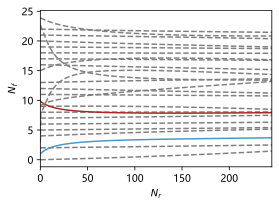

In [9]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
qls = list(range(max_ql))

for ql in qls:
    linestyle = '-'
    if ql == 1:
        color = '#4999c3'
    elif ql == 10:
        color = 'brown'
    else:
        color = 'grey'
        linestyle = '--'
    dressed_idx_arr = overlap_idx_arr[ql]
    photon_num_arr = np.zeros((max_ol))
    fluxonium_num_arr = np.zeros((max_ol))
    for ol in range(max_ol):
        state_after_a = resonator_destory_arr @ system.evecs[dressed_idx_arr[ol]].full()
        photon_num_arr[ol] = np.sum(state_after_a**2)
        state_after_fluxnonium_a = fluxonium_destory_arr @ system.evecs[dressed_idx_arr[ol]].full()
        fluxonium_num_arr[ol] = np.sum(state_after_fluxnonium_a**2)

    ax.plot(photon_num_arr,fluxonium_num_arr,label=f'{ql}',color=color,linestyle=linestyle)


ax.set_xlim(0,max_ol-5)
ax.set_xlabel(r'$N_r$')
ax.set_ylabel(r'$N_f$')

plt.tight_layout()

In [5]:
initial_states  = [
    qutip.basis(max_ql * max_ol, system.product_to_dressed[(ql,0)]) for ql in [0,1,2]
    ]
products_to_keep_list = [
    [[ql, ol] for ql in [0] for ol in range(max_ol) ],
    [[ql, ol] for ql in [1] for ol in range(max_ol) ],
    [[ql, ol] for ql in [2] for ol in range(max_ol) ]
]

list_of_systems = []
list_of_kwargs = []
for products_to_keep, y0 in zip(products_to_keep_list, initial_states):
    system.set_new_product_to_keep(products_to_keep)
    system.set_new_operators_after_setting_new_product_to_keep()
    list_of_systems.append(deepcopy(system))
    list_of_kwargs.append( {
        'y0':system.truncate_function(y0) ,
        'tlist':tlist,
        'drive_terms':[DriveTerm( 
                            driven_op= system.driven_operator,
                            pulse_shape_func=square_pulse_with_rise_fall,
                            pulse_shape_args={
                                'w_d': w_d ,
                                'amp': amp,
                                't_rise': 20,
                                't_square': tot_time
                            })],
        'e_ops':[system.a_trunc , system.a_trunc.dag()*system.a_trunc],
        # 'c_ops':[kappa *qutip.lindblad_dissipator(system.a_trunc) ]
        })
    

results = run_parallel_ODEsolve_and_post_process_jobs_with_different_systems(
    list_of_systems,
    list_of_kwargs,
    post_processing = ['pad_back']
)

import pickle
with open('sesolve_large_dim_a015.pkl', 'wb') as file:
    pickle.dump(results, file)

 Total run time: 1037.32s] Elapsed 1037.31s / Remaining 00:00:00:00[*******  29%           ] Elapsed 353.87s / Remaining 00:00:14:26


Processing states with pad_back_custom:   3%|▎         | 33/1000 [00:00<00:09, 102.06it/s]

 [*********72%*****      ] Elapsed 1037.72s / Remaining 00:00:06:43

Processing states with pad_back_custom:   8%|▊         | 77/1000 [00:00<00:09, 102.22it/s]

 [*********98%***********] Elapsed 1038.03s / Remaining 00:00:00:21

Processing states with pad_back_custom:  14%|█▍        | 143/1000 [00:01<00:08, 102.70it/s]

 [*********98%***********] Elapsed 1038.68s / Remaining 00:00:00:21

Processing states with pad_back_custom:  21%|██        | 209/1000 [00:02<00:07, 103.12it/s]

 [*********72%*****      ] Elapsed 1039.51s / Remaining 00:00:06:44

Processing states with pad_back_custom:  28%|██▊       | 275/1000 [00:02<00:07, 100.76it/s]

 [*********99%***********] Elapsed 1040.10s / Remaining 00:00:00:10

Processing states with pad_back_custom:  32%|███▏      | 319/1000 [00:03<00:06, 102.56it/s]

 [*********72%*****      ] Elapsed 1040.40s / Remaining 00:00:06:44

Processing states with pad_back_custom:  36%|███▋      | 363/1000 [00:03<00:06, 102.40it/s]

 [*********99%***********] Elapsed 1040.84s / Remaining 00:00:00:10

Processing states with pad_back_custom:  41%|████      | 407/1000 [00:03<00:05, 102.85it/s]

 [*********72%*****      ] Elapsed 1041.28s / Remaining 00:00:06:44

Processing states with pad_back_custom:  43%|████▎     | 429/1000 [00:04<00:05, 102.85it/s]

 [*********99%***********] Elapsed 1041.58s / Remaining 00:00:00:10

Processing states with pad_back_custom:  50%|████▉     | 495/1000 [00:04<00:04, 103.13it/s]

 [*********99%***********] Elapsed 1042.33s / Remaining 00:00:00:10

Processing states with pad_back_custom:  58%|█████▊    | 583/1000 [00:05<00:04, 101.07it/s]

 [*********99%***********] Elapsed 1043.09s / Remaining 00:00:00:10

Processing states with pad_back_custom:  67%|██████▋   | 670/1000 [00:06<00:03, 100.26it/s]

 [*********73%*****      ] Elapsed 1043.94s / Remaining 00:00:06:26

Processing states with pad_back_custom:  74%|███████▎  | 736/1000 [00:07<00:02, 101.72it/s]

 [*********73%*****      ] Elapsed 1044.79s / Remaining 00:00:06:26

Processing states with pad_back_custom:  82%|████████▏ | 824/1000 [00:08<00:01, 100.50it/s]

 [*********99%***********] Elapsed 1045.35s / Remaining 00:00:00:10

Processing states with pad_back_custom:  85%|████████▍ | 846/1000 [00:08<00:01, 100.30it/s]

 [*********73%*****      ] Elapsed 1045.64s / Remaining 00:00:06:26

Processing states with pad_back_custom:  89%|████████▉ | 890/1000 [00:08<00:01, 101.47it/s]

 [*********99%***********] Elapsed 1046.08s / Remaining 00:00:00:10

Processing states with pad_back_custom:  93%|█████████▎| 934/1000 [00:09<00:00, 102.40it/s]

 [*********73%*****      ] Elapsed 1046.48s / Remaining 00:00:06:27

Processing states with pad_back_custom:  96%|█████████▌| 956/1000 [00:09<00:00, 102.23it/s]

 [********100%***********] Elapsed 1046.81s / Remaining 00:00:00:00

Processing states with pad_back_custom: 100%|██████████| 1000/1000 [00:09<00:00, 101.53it/s]


 Total run time: 1049.74s] Elapsed 1049.74s / Remaining 00:00:00:00
 [*********73%*****      ] Elapsed 1049.79s / Remaining 00:00:06:28

Processing states with pad_back_custom:   9%|▉         | 89/1000 [00:00<00:09, 93.24it/s]

 [*********73%*****      ] Elapsed 1050.61s / Remaining 00:00:06:28

Processing states with pad_back_custom:  15%|█▍        | 149/1000 [00:01<00:09, 92.57it/s]

 [*********74%*****      ] Elapsed 1051.41s / Remaining 00:00:06:09

Processing states with pad_back_custom:  23%|██▎       | 229/1000 [00:02<00:08, 92.76it/s]

 [*********74%*****      ] Elapsed 1052.21s / Remaining 00:00:06:09

Processing states with pad_back_custom:  31%|███       | 309/1000 [00:03<00:07, 91.51it/s]

 [*********74%*****      ] Elapsed 1053.03s / Remaining 00:00:06:09

Processing states with pad_back_custom:  37%|███▋      | 369/1000 [00:03<00:06, 92.80it/s]

 [*********74%*****      ] Elapsed 1053.84s / Remaining 00:00:06:10

Processing states with pad_back_custom:  45%|████▍     | 449/1000 [00:04<00:06, 89.77it/s]

 [*********74%*****      ] Elapsed 1054.64s / Remaining 00:00:06:10

Processing states with pad_back_custom:  53%|█████▎    | 529/1000 [00:05<00:05, 91.60it/s]

 [*********74%*****      ] Elapsed 1055.43s / Remaining 00:00:06:10

Processing states with pad_back_custom:  59%|█████▉    | 589/1000 [00:06<00:04, 92.47it/s]

 [*********74%*****      ] Elapsed 1056.22s / Remaining 00:00:06:11

Processing states with pad_back_custom:  67%|██████▋   | 669/1000 [00:07<00:03, 92.90it/s]

 [*********74%*****      ] Elapsed 1057.00s / Remaining 00:00:06:11

Processing states with pad_back_custom:  73%|███████▎  | 729/1000 [00:07<00:02, 93.84it/s]

 [*********74%*****      ] Elapsed 1057.77s / Remaining 00:00:06:11

Processing states with pad_back_custom:  81%|████████  | 809/1000 [00:08<00:02, 94.29it/s]

 [*********74%*****      ] Elapsed 1058.52s / Remaining 00:00:06:11

Processing states with pad_back_custom:  89%|████████▉ | 889/1000 [00:09<00:01, 95.57it/s]

 [*********74%*****      ] Elapsed 1059.27s / Remaining 00:00:06:12

Processing states with pad_back_custom:  95%|█████████▍| 949/1000 [00:10<00:00, 95.49it/s]

 [*********75%*****      ] Elapsed 1060.01s / Remaining 00:00:05:53

Processing states with pad_back_custom: 100%|██████████| 1000/1000 [00:10<00:00, 92.79it/s]


 Total run time: 1290.65s] Elapsed 1290.65s / Remaining 00:00:00:00


Processing states with pad_back_custom: 100%|██████████| 1000/1000 [00:10<00:00, 99.93it/s]


In [3]:
with open('sesolve_large_dim_a015.pkl', 'rb') as file:
    results = pickle.load(file)

(0.0, 500.0)

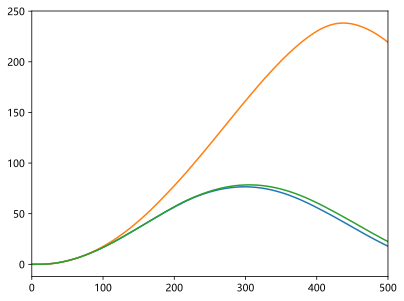

In [6]:
for i in [0,1,2]:
    plt.plot(results[i].expect[1])
plt.xlim(0,500)

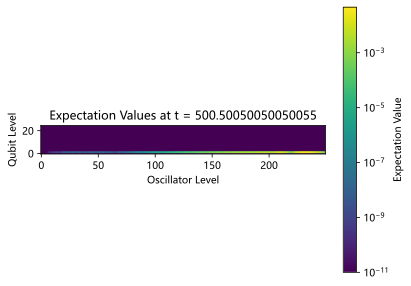

In [7]:
from CoupledQuantumSystems.visualization import *
plot_heatmap(results[1],500,system.product_to_dressed,max_ql,max_ol,LogNorm())